In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy
import re
import scipy.stats as stats

In [3]:
#NASA Exoplanet Archieve of WASP-17b
# https://exoplanetarchive.ipac.caltech.edu/overview/WASP-17b

In [4]:
df = pd.read_csv("wasp_17b_parameters.csv")#, header=None)
df = df.drop(columns=df.columns[0])


In [5]:
df

,Stassun et al. 2017,Patel & Espinoza 2022,Ivshina & Winn 2022,Bonomo et al. 2017,Barstow et al. 2017,Sedaghati et al. 2016,Sing et al. 2016,Knutson et al. 2014,Southworth et al. 2012,Anderson et al. 2011,Triaud et al. 2010,Anderson et al. 2010,Alderson et al. 2022
0,0,---,---,0.020,---,0,---,0.039+0.050-0.027,0,0.028+0.015-0.018,0.11,0.129+0.106-0.068,---
1,86.63+/-0.42,---,---,86.83+0.68-0.53,---,87.06+0.61-0.63,---,---,86.71+/-0.30,86.83+0.68-0.56,86.63+0.39-0.45,87.8+2.0-1.0,---
2,3.735430+/-0.000008,3.7354300+0.0000071-0.0000074,3.7354826+/-0.0000015,3.7354845+/-0.0000019,---,3.735438,3.73,---,3.7354845+/-0.0000019,3.7354380+/-0.0000068,3.7354330+0.0000076-0.0000075,3.7354417+0.0000072-0.0000073,3.73548546+/-0.00000027
3,1.87+/-0.24,---,---,1.991+/-0.081,---,1.747+/-0.078,1.89,---,1.932+/-0.053,1.991+/-0.081,1.986+0.089-0.074,1.74+0.26-0.23,---
4,---,---,---,0.05151+/-0.00035,---,0.0513+/-0.0029,---,---,0.05125+/-0.00103,0.05150+/-0.00034,0.0500+/-0.0017,0.051+0.0017-0.0018,---
5,---,0.180+0.130-0.100,---,---,---,0.361+/-0.069,---,---,---,0.401+0.059-0.077,0.400+0.043-0.040,---,---
6,---,0.1218+0.0016-0.0014,---,---,---,0.12345+/-0.00109,---,---,0.1255+/-0.0007,---,0.12929+0.00077-0.00061,---,---
7,---,---,---,---,---,90,---,179+/-120,---,-70.6,---,290+106-16,---
8,#1f77b4,#ff7f0e,#2ca02c,#d62728,#9467bd,#8c564b,#e377c2,#7f7f7f,#bcbd22,#17becf,b,g,m


In [6]:
def read_df_params(df_param_list, df_ref_list, add_none=False):
    """
    Reading a row of literature values for a given parameter and converting 
    it into an array.

    Format that it will be converted to: [value, +error, -error]

    Format reading examples:
    "0.028+/-0.015" -> [0.028, 0.015, -0.015]
    "0.3+0.5-0.1" -> [0.3, 0.5, -0.1]
    "3.0" -> [3.0, 0.0, 0.0]


    Parameters
    ----------
    df_params_list : array_like, str
        Array of literature values of a given parameter.

    df_ref_list : array_like, str
        Array of authors/references that published the given parameter.

    add_none : bool
        False -> Only return values that authors have published
        True  -> Return all values     

    Returns
    -------
        param_list : ndarray
            An array of [value, +error, -error].
        
        ref_list : ndarray, str
            An array of authors.
    
    """

    param_list = []
    ref_list = []

    p_mask = np.where(df_param_list=="---", False, True) #Masking values

    for param, pmask, ref in zip(df_param_list, p_mask, df_ref_list):
        if pmask == True:
            if "+/-" in param: #If param in format "123+/-12"
                param = re.split('\+\/\-', param)
                param = [float(param[0]), float(param[1]), float('-' + param[1])]

            elif ("+" in param) and ("-" in param): #If param in format "123+12-23"
                if param[0] == "-": #If param value is negative
                    param = e[1:]
                    param_tmp = re.split('\+|\-', param)
                    param = [float(param_tmp[0]), float(param_tmp[1]), float('-' + param_tmp[1])]

                else: #param value is positive
                    param_tmp = re.split('\+|\-', param)
                    param = [float(param_tmp[0]), float(param_tmp[1]), float('-' + param_tmp[1])]
                    
            else: #If param value has no error
                param = [float(param), 0.0, 0.0]

            param_list.append(param)
            ref_list.append(ref)

        if (add_none == True) and (pmask == False):
            param_list.append(None)
            ref_list.append(ref)


    param_list = np.array(param_list)
    ref_list = np.array(ref_list)

    return [param_list, ref_list]
        

In [7]:
df_ref_list = df.columns

df_e_list = df.loc[0] #Eccentricty row
df_i_list = df.loc[1] #Orbtial inclination row
df_P_list = df.loc[2] #Orbtial period row
df_R_list = df.loc[3] #Planetary radius row
df_a_list = df.loc[4] #Semi-major axis row
df_b_list = df.loc[5] #Impact parameter row
df_RpRs_list = df.loc[6] #R_p/R_star row
df_w_list = df.loc[7]
df_color = df.loc[8] #Colours

e_list, e_ref_list = read_df_params(df_e_list, df_ref_list)
i_list, i_ref_list = read_df_params(df_i_list, df_ref_list)
P_list, P_ref_list = read_df_params(df_P_list, df_ref_list)
R_list, R_ref_list = read_df_params(df_R_list, df_ref_list)
a_list, a_ref_list = read_df_params(df_a_list, df_ref_list)
b_list, b_ref_list = read_df_params(df_b_list, df_ref_list)
RpRs_list, RpRs_ref_list = read_df_params(df_RpRs_list, df_ref_list)



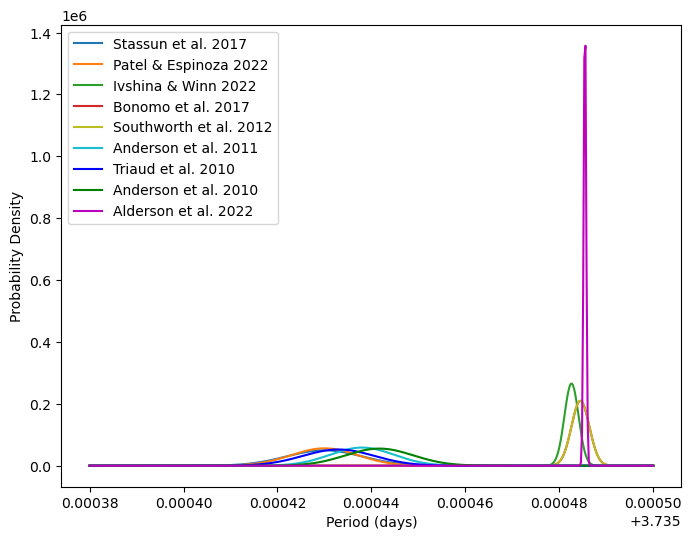

In [14]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(3.73538, 3.7355, 500)
for P_obj, author in zip(P_list, P_ref_list):
    mu, upper, lower = P_obj
    sigma = max(abs(upper), abs(lower))
    if sigma > 0:
        colour = df[author][8]
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=author, color=colour)

plt.xlabel("Period (days)")
plt.ylabel("Probability Density")
ax.legend()
plt.show()

#Same graph seen in https://doi.org/10.1093/mnras/stac661

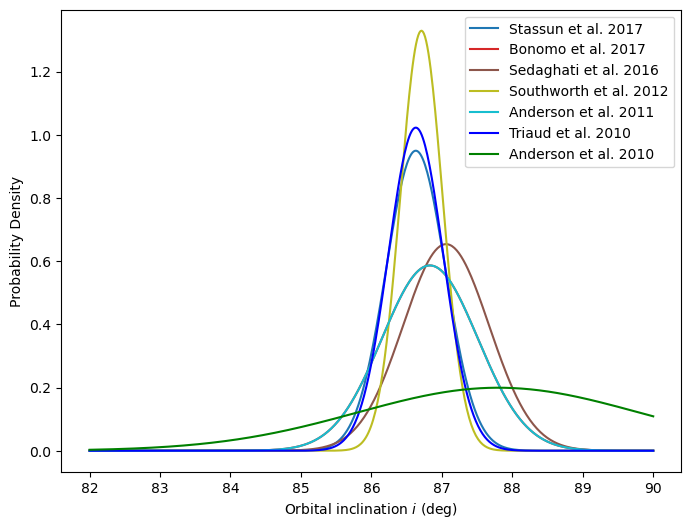

In [9]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(82, 90, 500)
for i_obj, author in zip(i_list, i_ref_list):
    mu, upper, lower = i_obj
    sigma = max(abs(upper), abs(lower))
    if sigma > 0:
        colour = df[author][8]
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=author, color=colour)

plt.xlabel(r"Orbital inclination $i$ (deg)")
plt.ylabel("Probability Density")
ax.legend()
plt.show()

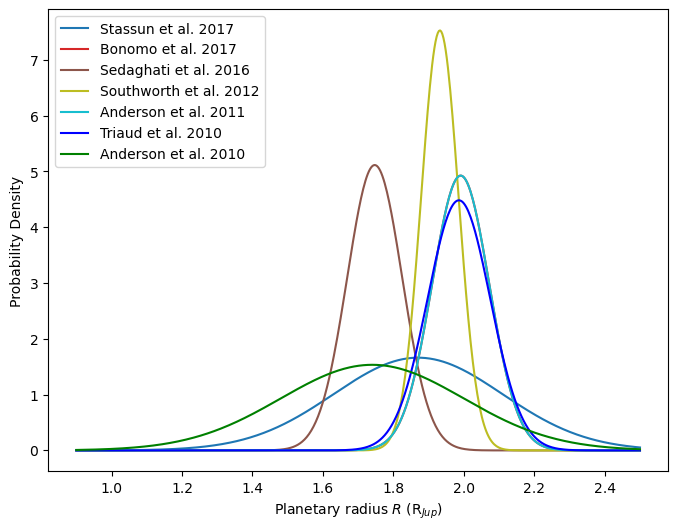

In [10]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(0.9, 2.5, 500)
for R_obj, author in zip(R_list, R_ref_list):
    mu, upper, lower = R_obj
    sigma = max(abs(upper), abs(lower))
    if sigma > 0:
        colour = df[author][8]
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=author, color=colour)

plt.xlabel(r'Planetary radius $R$ (R$_{Jup}$)')
plt.ylabel("Probability Density")
ax.legend()
plt.show()

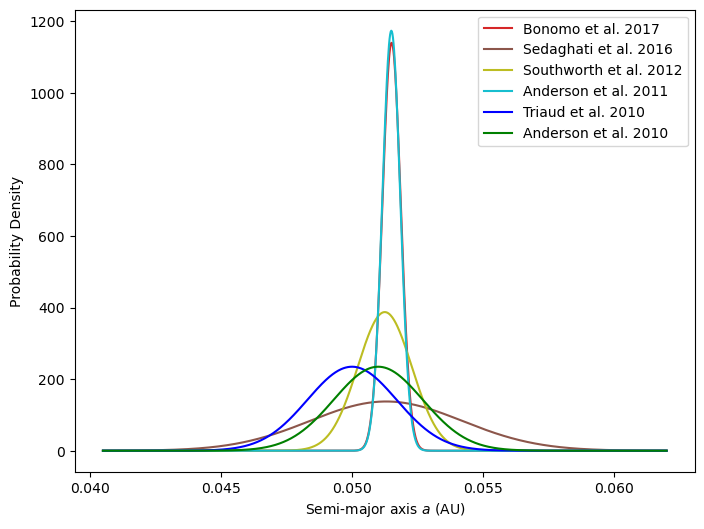

In [11]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(0.0405, 0.062, 1000)
for a_obj, author in zip(a_list, a_ref_list):
    mu, upper, lower = a_obj
    sigma = max(abs(upper), abs(lower))
    if sigma > 0:
        colour = df[author][8]
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=author, color=colour)

plt.xlabel(r'Semi-major axis $a$ (AU)')
plt.ylabel("Probability Density")
ax.legend()
plt.show()

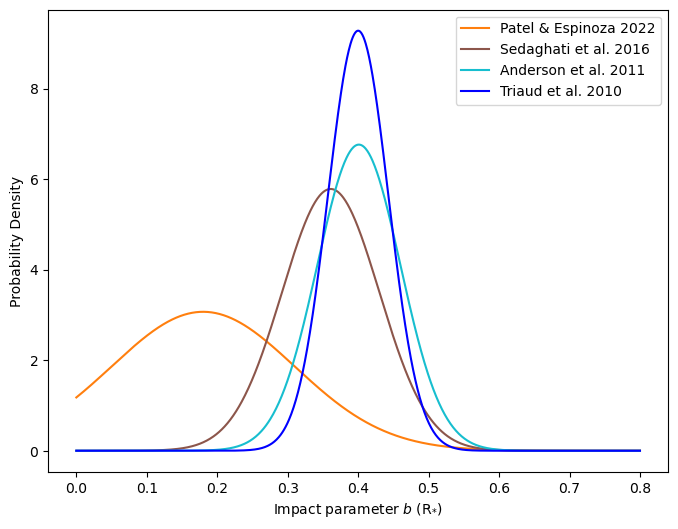

In [12]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(0.0, 0.8, 1000)
for b_obj, author in zip(b_list, b_ref_list):
    mu, upper, lower = b_obj
    sigma = max(abs(upper), abs(lower))
    if sigma > 0:
        colour = df[author][8]
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=author, color=colour)

plt.xlabel(r'Impact parameter $b$ (R$_{*}$)')
plt.ylabel("Probability Density")
ax.legend()
plt.show()

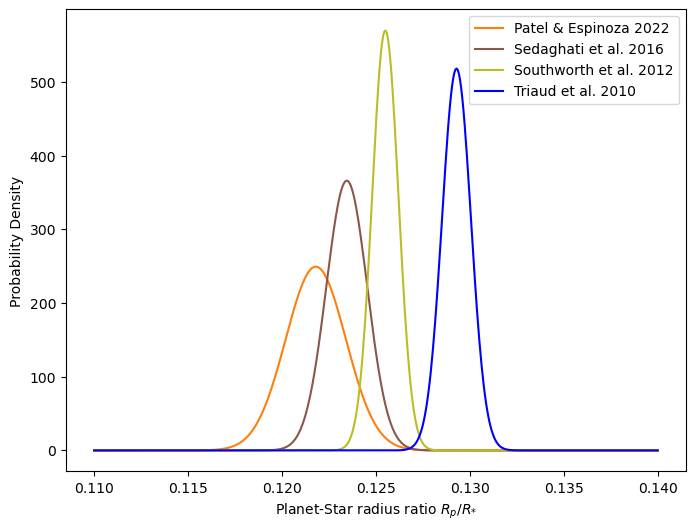

In [13]:
fig, ax = plt.subplots(1, figsize=(8,6))

x = np.linspace(0.11, 0.14, 500)
for RpRs_obj, author in zip(RpRs_list, RpRs_ref_list):
    mu, upper, lower = RpRs_obj
    sigma = max(abs(upper), abs(lower))
    if sigma > 0:
        colour = df[author][8]
        plt.plot(x, stats.norm.pdf(x, mu, sigma), label=author, color=colour)

plt.xlabel(r'Planet-Star radius ratio $R_{p}/R_{*}$')
plt.ylabel("Probability Density")
ax.legend()
plt.show()